In [2]:
!pip install torch torchvision

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/0d/4a/e51420d46cfc90562e85af2fee912237c662ab31140ab179e49bd69401d6/torch-2.5.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/69/55/ce836703ff77bb21582c3098d5311f8ddde7eadc7eab04be9561961f4725/torchvision-0.20.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/203.1 MB 1.3 MB/s eta 0:02:39

In [7]:
# We are importing libraries here and declaring some constants
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

batch_size = 32
learning_rate = 0.001
num_classes = 10


In [8]:
# Here we declare transformations for the training and test sets
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomCrop(32, padding=4),  
    transforms.ToTensor(),  
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Now we will load the CIFAR-10 dataset
training_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# We split the training dataset into train and validation sets
training_size = int(0.8 * len(training_set))
validation_size = len(training_set) - training_size
training_set, validation_set = random_split(training_set, [training_size, validation_size])
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
# We will now verify data loading
img, lbl = next(iter(training_loader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {lbl.shape}")

Image shape: torch.Size([32, 3, 32, 32])
Label shape: torch.Size([32])


In [16]:
# We now load the ResNet-18 model
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# optimize using learning rate we defined earlier
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=learning_rate, momentum=0.9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)


In [22]:
# We will train the model using training set
def train_one_epoch(resnet_model, data_loader, criterion, optimizer, device):
    resnet_model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  

        outputs = resnet_model(images)  
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step() 
        running_loss += loss.item()
        _, predicted = outputs.max(1)  
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy


In [28]:
# Here we are evaluating model on validation set
def validate(resnet_model, data_loader, criterion, device):
    resnet_model.eval()  
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for img, lbl in data_loader:
            img, lbl = img.to(device), lbl.to(device)

            outputs = resnet_model(img)
            loss = criterion(outputs, lbl)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(lbl).sum().item()
            total += lbl.size(0)

    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy

In [32]:
# Training and getting results
epochs = 15 
train_accuracies, val_accuracies = [], []
for i in range(epochs):
    train_loss, train_accuracy = train_one_epoch(resnet_model, training_loader, criterion, optimizer, device)
    validation_loss, validation_accuracy = validate(resnet_model, validation_loader, criterion, device)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(validation_accuracy)
    
    print(f"Epoch [{i+1}/{epochs}] - Training Loss: {train_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}% | Validation Loss: {validation_loss:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.2f}%")


Epoch [1/15] - Training Loss: 1.3485, Training Accuracy: 51.38% | Validation Loss: 1.2533, Validation Accuracy: 55.60%
Epoch [2/15] - Training Loss: 1.2449, Training Accuracy: 55.34% | Validation Loss: 1.1988, Validation Accuracy: 56.92%
Epoch [3/15] - Training Loss: 1.1651, Training Accuracy: 58.34% | Validation Loss: 1.1042, Validation Accuracy: 60.41%
Epoch [4/15] - Training Loss: 1.0908, Training Accuracy: 61.18% | Validation Loss: 1.0524, Validation Accuracy: 62.33%
Epoch [5/15] - Training Loss: 1.0413, Training Accuracy: 62.99% | Validation Loss: 1.0052, Validation Accuracy: 64.69%
Epoch [6/15] - Training Loss: 0.9986, Training Accuracy: 64.50% | Validation Loss: 0.9882, Validation Accuracy: 65.30%
Epoch [7/15] - Training Loss: 0.9563, Training Accuracy: 65.98% | Validation Loss: 0.9271, Validation Accuracy: 66.91%
Epoch [8/15] - Training Loss: 0.9238, Training Accuracy: 67.16% | Validation Loss: 0.9416, Validation Accuracy: 66.82%
Epoch [9/15] - Training Loss: 0.8943, Training A

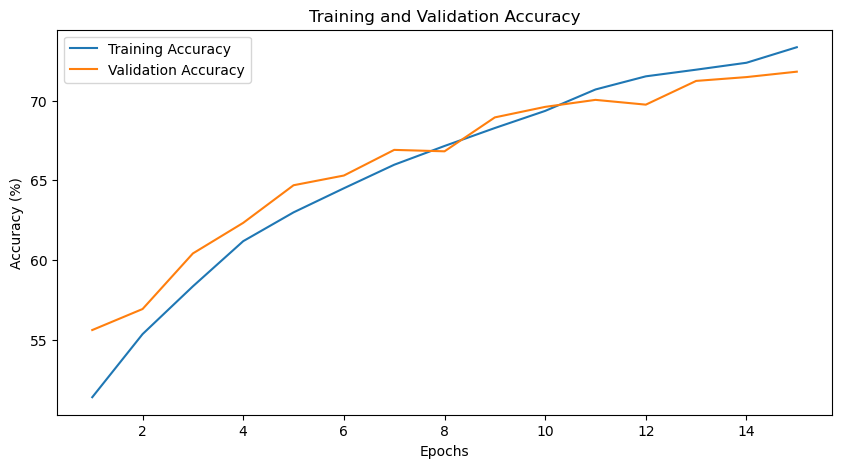

In [36]:
# Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [38]:
# Evaluating the test set
def test(resnet_model, data_loader, criterion, device):
    resnet_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): 
        for img, lbl in data_loader:
            img, lbl = img.to(device), lbl.to(device)

            outputs = resnet_model(img)
            loss = criterion(outputs, lbl)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(lbl).sum().item()
            total += lbl.size(0)

    test_loss = running_loss / len(data_loader)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy

test_loss, test_accuracy = test(resnet_model, testing_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.8139, Test Accuracy: 71.43%


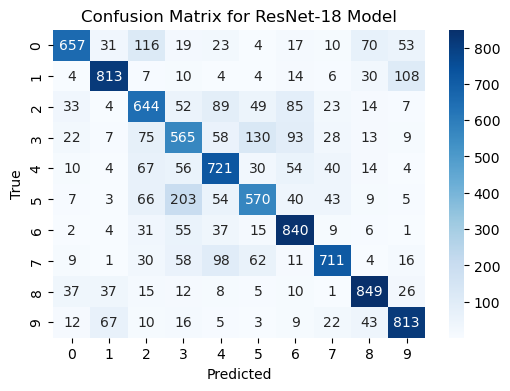

In [43]:
# Confusion Matrix printing
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

resnet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():  
    for img, lbl in testing_loader:
        img, lbl = img.to(device), lbl.to(device)
        outputs = resnet_model(img)
        _, preds = torch.max(outputs, 1)  

        all_preds.extend(preds.cpu().numpy()) 
        all_labels.extend(lbl.cpu().numpy())  
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ResNet-18 Model')
plt.show()

### MOBILENET MODEL IMPLEMENTATION:

In [54]:
# Loading MobileNet for CIFAR-10
mobilenet_model = models.mobilenet_v2(weights=None)
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, num_classes)
mobilenet_model = mobilenet_model.to(device)

In [60]:
# We are defining the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=learning_rate)

In [61]:
# Training mobilenet model
mobilenet_train_accuracies, mobilenet_val_accuracies = [], []

for i in range(epochs):
    train_loss, train_accuracy = train_one_epoch(mobilenet_model, training_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(mobilenet_model, validation_loader, criterion, device)
    
    mobilenet_train_accuracies.append(train_accuracy)
    mobilenet_val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{i+1}/{epochs}] - Training Loss: {train_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}% | Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/15] - Training Loss: 2.0687, Training Accuracy: 22.75% | Validation Loss: 1.8017, Validation Accuracy: 32.48%
Epoch [2/15] - Training Loss: 1.7730, Training Accuracy: 34.07% | Validation Loss: 1.6447, Validation Accuracy: 38.11%
Epoch [3/15] - Training Loss: 1.6452, Training Accuracy: 39.31% | Validation Loss: 1.4939, Validation Accuracy: 45.24%
Epoch [4/15] - Training Loss: 1.5352, Training Accuracy: 43.41% | Validation Loss: 1.4257, Validation Accuracy: 48.32%
Epoch [5/15] - Training Loss: 1.4307, Training Accuracy: 48.25% | Validation Loss: 1.3014, Validation Accuracy: 53.49%
Epoch [6/15] - Training Loss: 1.3404, Training Accuracy: 52.34% | Validation Loss: 1.2081, Validation Accuracy: 57.48%
Epoch [7/15] - Training Loss: 1.2563, Training Accuracy: 55.83% | Validation Loss: 1.1636, Validation Accuracy: 58.54%
Epoch [8/15] - Training Loss: 1.1832, Training Accuracy: 58.81% | Validation Loss: 1.1407, Validation Accuracy: 60.60%
Epoch [9/15] - Training Loss: 1.1272, Training A

In [63]:
# Running Test Evaluation for MobileNet:
def test(mobilenet_model, data_loader, criterion, device):
    mobilenet_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for img, lbl in data_loader:
            img, lbl = img.to(device), lbl.to(device)

            outputs = mobilenet_model(img)
            loss = criterion(outputs, lbl)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(lbl).sum().item()
            total += lbl.size(0)

    # Calculate average loss and accuracy
    test_loss = running_loss / len(data_loader)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy

# Run the test evaluation for MobileNet
test_loss, test_accuracy = test(mobilenet_model, testing_loader, criterion, device)
print(f"MobileNet Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


MobileNet Test Loss: 0.8404, Test Accuracy: 71.03%


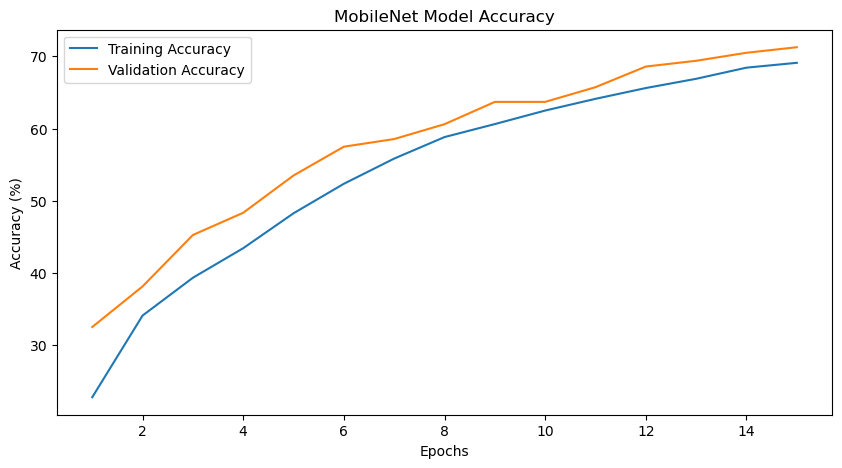

In [64]:
# Plot Mobilenet Model

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), mobilenet_train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), mobilenet_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('MobileNet Model Accuracy')
plt.legend()
plt.show()

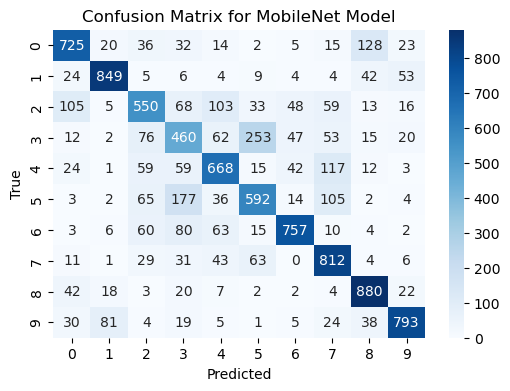

In [65]:
# Confusion Matrix for the same
mobilenet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad(): 
    for img, lbl in testing_loader:
        img, lbl = img.to(device), lbl.to(device)
        op = mobilenet_model(img)
        _, preds = torch.max(op, 1) 

        all_preds.extend(preds.cpu().numpy()) 
        all_labels.extend(lbl.cpu().numpy())  

cm_mobilenet = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mobilenet, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for MobileNet Model')
plt.show()
